<a href="https://colab.research.google.com/github/elmomote/DL2024-FacialKeypointDetectionProject/blob/main/%5BF24_DL%5D_Facial_Keypoint_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **The Project**

The Facial Keypoint Detection Competition from Kaggle consists of creating a model that receives grayscale images of shape 96x96 and make 30 predictions based on those images.

### **The Plan**

The plan in this project is to split up and make two models. Try our best, make some good documentation, and at the end. Observe the best out of both models to make one final model.

# Loading Data set from Kaggle

In [ ]:
from google.colab import files
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip
!unzip training.zip
!unzip test.zip


Saving kaggle.json to kaggle.json
 85% 65.0M/76.3M [00:00<00:00, 89.3MB/s]
100% 76.3M/76.3M [00:00<00:00, 96.4MB/s]
Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


## Sample Image

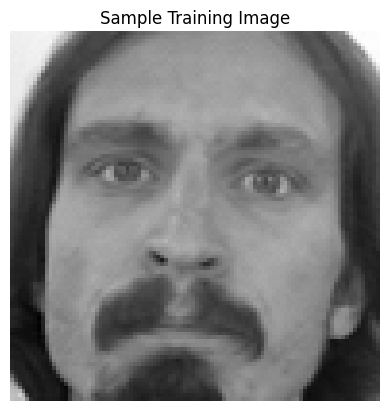

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
image_index = 0  # Change this to display a different image
image = data['Image'][image_index].reshape(96, 96)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Sample Training Image")
plt.show()


## Sample Image with Key points

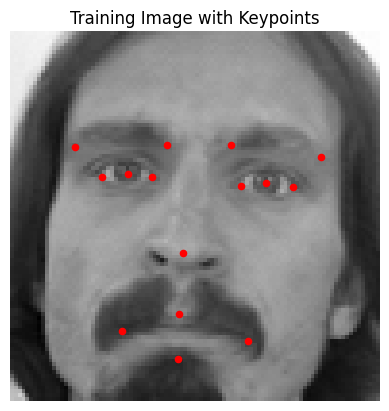

In [ ]:
keypoints = data.iloc[image_index, :-1].values  # All columns except the 'Image'
keypoints = keypoints.astype(float).reshape(-1, 2)  # Reshape into (x, y) pairs

plt.imshow(image, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='red', marker='o')
plt.axis('off')
plt.title("Training Image with Keypoints")
plt.show()


# Model 1

In [ ]:
# Load and preprocess data
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
data.dropna(inplace=True)  # Drop rows with missing keypoints

# Prepare input and output
images = np.stack(data['Image'].values).reshape(-1, 96, 96, 1) / 255.0  # Normalize pixel values
keypoints = data.drop(columns=['Image']).values  # Keypoints as targets

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, keypoints, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(30)  # 15 keypoints * 2 coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Visualize predictions
def visualize_predictions(index):
    img = X_val[index].reshape(96, 96)
    true_keypoints = y_val[index].reshape(-1, 2)
    predicted_keypoints = model.predict(X_val[index:index+1]).reshape(-1, 2)

    plt.imshow(img, cmap='gray')
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], c='green', label='True', s=20)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='red', label='Predicted', s=20)
    plt.legend()
    plt.title('True vs Predicted Keypoints')
    plt.axis('off')
    plt.show()

# Visualize predictions for a random sample
visualize_predictions(0)  # Change the index to view other samples


# Model 2